In [85]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))
from utils import missing_values_table, fix_outlier, convert_bytes_to_megabytes, convert_ms_to_seconds
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [3]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))

from load_data import load_data_from_postgres

In [4]:
query = "SELECT * FROM xdr_data"

In [5]:
df_postgres = load_data_from_postgres(query)
print("Data loaded using psycopg2:")

Data loaded using psycopg2:


In [6]:
df_postgres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

### Extracting User engagement columns

In [8]:
user_engagement_columns = [
    # Identifiers
    'IMSI', 'MSISDN/Number',

    # Session Duration Columns
    'Dur. (ms)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)',

    # Data Traffic Columns (Download and Upload)
    'Total DL (Bytes)', 'Total UL (Bytes)',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)',

    # QoS Columns
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)'
]


In [9]:
# Creating the df_user_engagement DataFrame with the selected columns
df_user_engagement = df_postgres[user_engagement_columns].copy()

### EDA on the extracted data


In [10]:
df_user_engagement.head()

,IMSI,MSISDN/Number,Dur. (ms),Activity Duration DL (ms),Activity Duration UL (ms),Total DL (Bytes),Total UL (Bytes),Social Media DL (Bytes),Social Media UL (Bytes),Youtube DL (Bytes),...,Email DL (Bytes),Email UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,2.082014e+14,3.366496e+10,1823652.0,37624.0,38787.0,308879636.0,36749741.0,1545765.0,24420.0,15854611.0,...,3563542.0,137762.0,278082303.0,14344150.0,171744450.0,8814393.0,42.0,5.0,23.0,44.0
1,2.082019e+14,3.368185e+10,1365104.0,168.0,3560.0,653384965.0,53800391.0,1926113.0,7165.0,20247395.0,...,629046.0,308339.0,608750074.0,1170709.0,526904238.0,15055145.0,65.0,5.0,16.0,26.0
2,2.082003e+14,3.376063e+10,1361762.0,0.0,0.0,279807335.0,27883638.0,1684053.0,42224.0,19725661.0,...,2690151.0,672973.0,229584621.0,395630.0,410692588.0,4215763.0,NaN,NaN,6.0,9.0
3,2.082014e+14,3.375034e+10,1321509.0,3330.0,37882.0,846028530.0,43324218.0,644121.0,13372.0,21388122.0,...,1439754.0,631229.0,799538153.0,10849722.0,749039933.0,12797283.0,NaN,NaN,44.0,44.0
4,2.082014e+14,3.369980e+10,1089009.0,0.0,0.0,569138589.0,38542814.0,862600.0,50188.0,15259380.0,...,1936496.0,173853.0,527707248.0,3529801.0,550709500.0,13910322.0,NaN,NaN,6.0,9.0


In [11]:
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   IMSI                       149431 non-null  float64
 1   MSISDN/Number              148935 non-null  float64
 2   Dur. (ms)                  150000 non-null  float64
 3   Activity Duration DL (ms)  150000 non-null  float64
 4   Activity Duration UL (ms)  150000 non-null  float64
 5   Total DL (Bytes)           150000 non-null  float64
 6   Total UL (Bytes)           150000 non-null  float64
 7   Social Media DL (Bytes)    150001 non-null  float64
 8   Social Media UL (Bytes)    150001 non-null  float64
 9   Youtube DL (Bytes)         150001 non-null  float64
 10  Youtube UL (Bytes)         150001 non-null  float64
 11  Netflix DL (Bytes)         150001 non-null  float64
 12  Netflix UL (Bytes)         150001 non-null  float64
 13  Google DL (Bytes)          15

In [12]:
df_user_engagement.shape

(150001, 25)

### Checking for missing values using imported function missing_values_table

In [13]:
missing_values_table(df_user_engagement)

Your selected dataframe has 25 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
Avg RTT DL (ms),27829,18.6
Avg RTT UL (ms),27812,18.5
MSISDN/Number,1066,0.7
IMSI,570,0.4
Dur. (ms),1,0.0
Activity Duration DL (ms),1,0.0
Activity Duration UL (ms),1,0.0
Total DL (Bytes),1,0.0
Total UL (Bytes),1,0.0
Avg Bearer TP DL (kbps),1,0.0


## cleaning the data by using different techniques 

In [14]:
df_user_engagement.dropna(subset=['MSISDN/Number'], inplace=True)
missing_values_table(df_user_engagement)

Your selected dataframe has 25 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Avg RTT DL (ms),27644,18.6
Avg RTT UL (ms),27625,18.5


### Filling the missing Values of the above fields with the mean of the respective columns

In [15]:

mean_rtt_dl = df_user_engagement['Avg RTT DL (ms)'].mean()
mean_rtt_ul = df_user_engagement['Avg RTT UL (ms)'].mean()

# Fill missing values with mean
df_user_engagement['Avg RTT DL (ms)'].fillna(mean_rtt_dl, inplace=True)
df_user_engagement['Avg RTT UL (ms)'].fillna(mean_rtt_ul, inplace=True)

## fixing outliers 

In [16]:
user_engagement_columns_to_apply_quartiles = ['Dur. (ms)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)',

    # Data Traffic Columns (Download and Upload)
    'Total DL (Bytes)', 'Total UL (Bytes)',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)',

    # QoS Columns
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

In [17]:
# Apply the fix_outlier function to each specified column
for column in user_engagement_columns_to_apply_quartiles:
    if column in df_user_engagement.columns:
        df_user_engagement = fix_outlier(df_user_engagement, column)

In [18]:
df_user_engagement.isnull().sum()

IMSI                         0
MSISDN/Number                0
Dur. (ms)                    0
Activity Duration DL (ms)    0
Activity Duration UL (ms)    0
Total DL (Bytes)             0
Total UL (Bytes)             0
Social Media DL (Bytes)      0
Social Media UL (Bytes)      0
Youtube DL (Bytes)           0
Youtube UL (Bytes)           0
Netflix DL (Bytes)           0
Netflix UL (Bytes)           0
Google DL (Bytes)            0
Google UL (Bytes)            0
Email DL (Bytes)             0
Email UL (Bytes)             0
Gaming DL (Bytes)            0
Gaming UL (Bytes)            0
Other DL (Bytes)             0
Other UL (Bytes)             0
Avg RTT DL (ms)              0
Avg RTT UL (ms)              0
Avg Bearer TP DL (kbps)      0
Avg Bearer TP UL (kbps)      0
dtype: int64

## Formatting the data

### Byte to Megabyte conversion

In [19]:
byte_columns = [
    'Total DL (Bytes)', 'Total UL (Bytes)',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'YouTube DL (Bytes)', 'YouTube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]


In [20]:
for column in byte_columns:
    if column in df_user_engagement.columns:
        df_user_engagement[column] = df_user_engagement[column].apply(convert_bytes_to_megabytes)

### Converting milliseconds to seconds

In [21]:
millisecond_columns_to_convert = [
    'Dur. (ms)',
    'Activity Duration DL (ms)',
    'Activity Duration UL (ms)',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)'
]


In [22]:
for column in millisecond_columns_to_convert:
    if column in df_user_engagement.columns:
        df_user_engagement[column] = df_user_engagement[column].apply(convert_ms_to_seconds)

### Renaming the converted colums

In [23]:
df_user_engagement.rename(columns=lambda x: x.replace('Bytes', 'Megabytes') if 'Bytes' in x else x, inplace=True)
df_user_engagement.rename(columns=lambda x: x.replace('(ms)', '(s)') if '(ms)' in x else x, inplace=True)

In [24]:
df_user_engagement.head()

,IMSI,MSISDN/Number,Dur. (s),Activity Duration DL (s),Activity Duration UL (s),Total DL (Megabytes),Total UL (Megabytes),Social Media DL (Megabytes),Social Media UL (Megabytes),Youtube DL (Megabytes),...,Email DL (Megabytes),Email UL (Megabytes),Gaming DL (Megabytes),Gaming UL (Megabytes),Other DL (Megabytes),Other UL (Megabytes),Avg RTT DL (s),Avg RTT UL (s),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,2.082014e+14,3.366496e+10,241.7635,37.6240,38.7870,294.570576,35.047284,1.474156,0.023289,15854611.0,...,3.248914,0.131380,265.199950,13.679647,163.788271,8.406060,0.042000,0.005000,23.0,44.0
1,2.082019e+14,3.368185e+10,241.7635,0.1680,3.5600,623.116460,51.308051,1.836884,0.006833,20247395.0,...,0.599905,0.294055,580.549311,1.116475,502.495039,14.357705,0.065000,0.005000,16.0,26.0
2,2.082003e+14,3.376063e+10,241.7635,0.1027,0.5897,266.845069,26.591909,1.606038,0.040268,19725661.0,...,2.565528,0.641797,218.948956,0.794487,391.666973,4.020465,0.108225,0.017637,11.0,18.0
3,2.082014e+14,3.375034e+10,241.7635,3.3300,37.8820,795.636628,41.317194,0.614282,0.012753,21388122.0,...,1.373056,0.601987,762.499002,10.347101,714.340146,12.204440,0.108225,0.017637,44.0,44.0
4,2.082014e+14,3.369980e+10,241.7635,0.1027,0.5897,542.772855,36.757292,0.822639,0.047863,15259380.0,...,1.846786,0.165799,503.260849,3.366281,525.197506,13.265917,0.108225,0.017637,11.0,18.0


## Aggregating the sessions frequency,duration and total traffic metrics per customer id (MSISDN)

### grouping data by mssisdn and aggregating the data

In [25]:
grouped_df = df_user_engagement.groupby('MSISDN/Number').agg({
    'Dur. (s)': 'sum',
    'Total DL (Megabytes)': 'sum',
    'Total UL (Megabytes)': 'sum',
    'Activity Duration DL (s)': 'sum',
    'Activity Duration UL (s)': 'sum'
}).reset_index()

In [26]:
grouped_df['Total Traffic (Megabytes)'] = grouped_df['Total DL (Megabytes)'] + grouped_df['Total UL (Megabytes)']


### Sorting and Reporting Top 10 Customers

In [27]:
top_10_duration = grouped_df.sort_values(by='Dur. (s)', ascending=False).head(10)
top_10_download = grouped_df.sort_values(by='Total DL (Megabytes)', ascending=False).head(10)
top_10_upload = grouped_df.sort_values(by='Total UL (Megabytes)', ascending=False).head(10)


In [28]:
print("Top 10 customers by session duration:")
print(top_10_duration)




Top 10 customers by session duration:
       MSISDN/Number   Dur. (s)  Total DL (Megabytes)  Total UL (Megabytes)  \
13180   3.362578e+10  4084.8840           7366.843254            691.216809   
13526   3.362632e+10  3960.5220           6949.816952            639.659152   
6437    3.361489e+10  3853.5000           7716.212252            664.505300   
37052   3.365973e+10  3459.1230           6763.731844            589.219769   
92923   3.376054e+10  3360.0935           7487.349087            669.830360   
76363   3.367588e+10  3298.7760           6970.185834            554.627220   
65118   3.366716e+10  3074.0770           4852.058868            547.243504   
666     3.360313e+10  2818.7455           4330.260670            425.369561   
13994   3.362708e+10  2748.9850           5063.513672            424.796318   
1279    3.360452e+10  2746.6780           4870.777380            390.770686   

       Activity Duration DL (s)  Activity Duration UL (s)  \
13180                  920.4097

In [29]:
print("Top 10 customers by total download traffic:")
top_10_download.head(10)

Top 10 customers by total download traffic:


,MSISDN/Number,Dur. (s),Total DL (Megabytes),Total UL (Megabytes),Activity Duration DL (s),Activity Duration UL (s),Total Traffic (Megabytes)
6437,3.361489e+10,3853.5000,7716.212252,664.505300,11033.8810,10625.1070,8380.717552
92923,3.376054e+10,3360.0935,7487.349087,669.830360,7167.5130,6634.2980,8157.179447
13180,3.362578e+10,4084.8840,7366.843254,691.216809,920.4097,889.7947,8058.060063
76363,3.367588e+10,3298.7760,6970.185834,554.627220,18439.6940,18075.7880,7524.813054
13526,3.362632e+10,3960.5220,6949.816952,639.659152,1859.6520,1487.8680,7589.476104
37052,3.365973e+10,3459.1230,6763.731844,589.219769,8941.9110,8615.9950,7352.951612
63028,3.366646e+10,2566.9835,6552.499856,386.296249,1397.2060,1260.0890,6938.796106
92577,3.376041e+10,2646.7575,6218.699247,496.463556,4560.0730,4127.5920,6715.162802
57241,3.366471e+10,2577.8980,6069.450232,460.921726,6781.5660,6352.8550,6530.371958
86455,3.369879e+10,2605.9480,5716.260738,496.309071,3671.0400,3503.9410,6212.569810


In [30]:
print("Top 10 customers by total upload traffic:")
top_10_upload.head(10)

Top 10 customers by total upload traffic:


,MSISDN/Number,Dur. (s),Total DL (Megabytes),Total UL (Megabytes),Activity Duration DL (s),Activity Duration UL (s),Total Traffic (Megabytes)
13180,3.362578e+10,4084.8840,7366.843254,691.216809,920.4097,889.7947,8058.060063
92923,3.376054e+10,3360.0935,7487.349087,669.830360,7167.5130,6634.2980,8157.179447
6437,3.361489e+10,3853.5000,7716.212252,664.505300,11033.8810,10625.1070,8380.717552
13526,3.362632e+10,3960.5220,6949.816952,639.659152,1859.6520,1487.8680,7589.476104
37052,3.365973e+10,3459.1230,6763.731844,589.219769,8941.9110,8615.9950,7352.951612
76363,3.367588e+10,3298.7760,6970.185834,554.627220,18439.6940,18075.7880,7524.813054
65118,3.366716e+10,3074.0770,4852.058868,547.243504,537.6980,466.2530,5399.302372
92577,3.376041e+10,2646.7575,6218.699247,496.463556,4560.0730,4127.5920,6715.162802
86455,3.369879e+10,2605.9480,5716.260738,496.309071,3671.0400,3503.9410,6212.569810
94654,3.376127e+10,2244.2500,4326.489569,467.445196,18649.2559,15317.4003,4793.934764


### Session Frequency

In [31]:
session_frequency = df_user_engagement.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')
grouped_df = grouped_df.merge(session_frequency, on='MSISDN/Number')
top_10_session_frequency = grouped_df.sort_values(by='Session Frequency', ascending=False).head(10)


In [32]:
print("Top 10 customers by session frequency:")
top_10_session_frequency.head(10)


Top 10 customers by session frequency:


,MSISDN/Number,Dur. (s),Total DL (Megabytes),Total UL (Megabytes),Activity Duration DL (s),Activity Duration UL (s),Total Traffic (Megabytes),Session Frequency
13526,3.362632e+10,3960.5220,6949.816952,639.659152,1859.6520,1487.8680,7589.476104,18
13180,3.362578e+10,4084.8840,7366.843254,691.216809,920.4097,889.7947,8058.060063,17
6437,3.361489e+10,3853.5000,7716.212252,664.505300,11033.8810,10625.1070,8380.717552,17
37052,3.365973e+10,3459.1230,6763.731844,589.219769,8941.9110,8615.9950,7352.951612,16
92923,3.376054e+10,3360.0935,7487.349087,669.830360,7167.5130,6634.2980,8157.179447,15
76363,3.367588e+10,3298.7760,6970.185834,554.627220,18439.6940,18075.7880,7524.813054,15
65118,3.366716e+10,3074.0770,4852.058868,547.243504,537.6980,466.2530,5399.302372,13
13994,3.362708e+10,2748.9850,5063.513672,424.796318,807.6240,812.2670,5488.309990,12
1279,3.360452e+10,2746.6780,4870.777380,390.770686,19278.1500,12381.1640,5261.548067,12
92577,3.376041e+10,2646.7575,6218.699247,496.463556,4560.0730,4127.5920,6715.162802,12


## Normalization and K-means clustering

In [33]:
columns_to_normalize = ['Dur. (s)', 'Total DL (Megabytes)', 'Total UL (Megabytes)', 'Session Frequency']
scaler = MinMaxScaler()
# Fit and transform the selected columns
grouped_df[columns_to_normalize] = scaler.fit_transform(grouped_df[columns_to_normalize])


### K-Means Clustering with k=3

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42)
grouped_df['Cluster'] = kmeans.fit_predict(grouped_df[columns_to_normalize])

In [35]:
#cluster centers to see the characteristics of each cluster
print("Cluster Centers (Centroids):")
print(kmeans.cluster_centers_)

Cluster Centers (Centroids):
[[0.04506139 0.11396645 0.09489203 0.06794515]
 [0.01993095 0.04736159 0.0272754  0.0010283 ]
 [0.12091874 0.24788378 0.2214498  0.19324007]]


### Visualization Total Traffic vs Total Duration

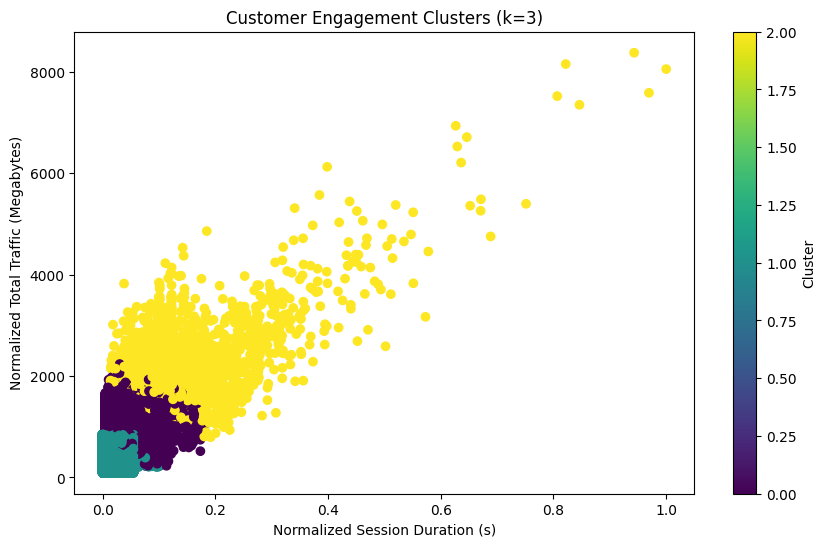

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['Dur. (s)'], grouped_df['Total Traffic (Megabytes)'], c=grouped_df['Cluster'], cmap='viridis')
plt.title("Customer Engagement Clusters (k=3)")
plt.xlabel("Normalized Session Duration (s)")
plt.ylabel("Normalized Total Traffic (Megabytes)")
plt.colorbar(label='Cluster')
plt.show()

### Visualization Total Traffic vs Total Session Frequency

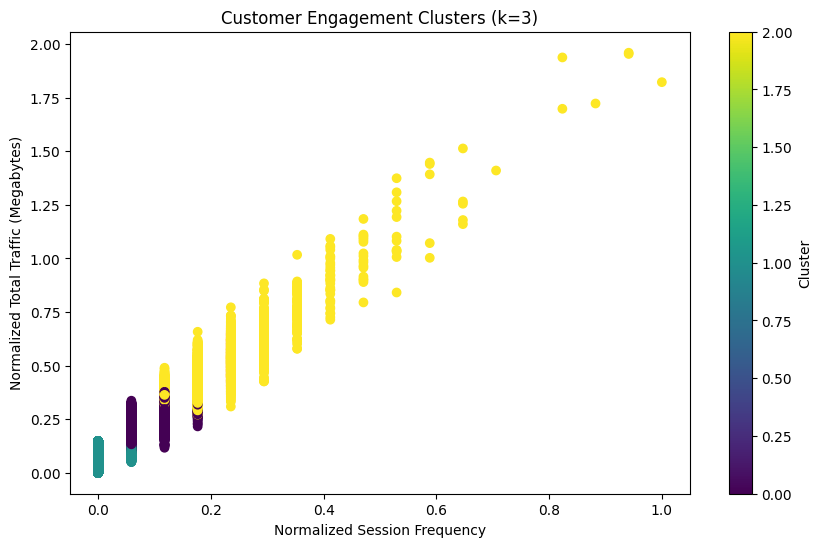

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['Session Frequency'], grouped_df['Total DL (Megabytes)'] + grouped_df['Total UL (Megabytes)'], 
            c=grouped_df['Cluster'], cmap='viridis')
plt.title("Customer Engagement Clusters (k=3)")
plt.xlabel("Normalized Session Frequency")
plt.ylabel("Normalized Total Traffic (Megabytes)")
plt.colorbar(label='Cluster')
plt.show()

## Minimum, maximum, average & total non-normalized metrics for each cluster

###  Grouping by Cluster and Calculate Statistics

In [38]:
cluster_stats = grouped_df.groupby('Cluster').agg({
    'Dur. (s)': ['min', 'max', 'mean', 'sum'],
    'Total DL (Megabytes)': ['min', 'max', 'mean', 'sum'],
    'Total UL (Megabytes)': ['min', 'max', 'mean', 'sum'],
    'Session Frequency': ['min', 'max', 'mean', 'sum']
}).reset_index()

In [39]:
cluster_stats

Cluster  Dur. (s)                                  Total DL (Megabytes)  \
                min       max      mean          sum                  min   
0       0  0.004915  0.179566  0.045044  1066.587253             0.009300   
1       1  0.000000  0.113149  0.019930  1576.667347             0.000000   
2       2  0.014058  1.000000  0.120892   491.788568             0.059278   

                                   Total UL (Megabytes)                      \
        max      mean          sum                  min       max      mean   
0  0.272094  0.113935  2697.878571             0.031950  0.224354  0.094871   
1  0.095762  0.047361  3746.682621             0.000000  0.108639  0.027273   
2  1.000000  0.247796  1008.032800             0.072067  1.000000  0.221347   

               Session Frequency                                   
           sum               min       max      mean          sum  
0  2246.442721          0.058824  0.176471  0.067931  1608.529412  
1  2157.557000          0.000000  0.058824  0.001025    81.058824  
2   900.438908          0.117647  1.000000  0.193129   785.647059

### Visualization of the Clusters

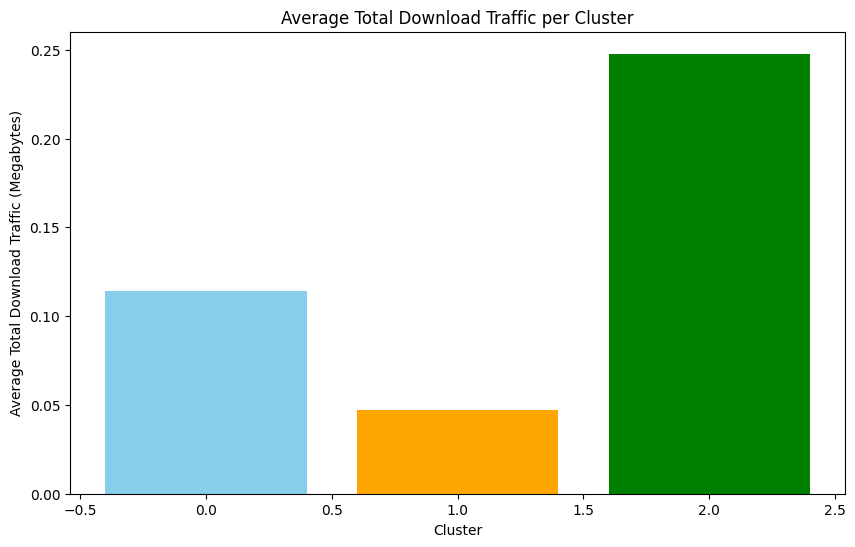

In [40]:
# Plotting average total download traffic per cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_stats['Cluster'], cluster_stats['Total DL (Megabytes)']['mean'], color=['skyblue', 'orange', 'green'])
plt.title("Average Total Download Traffic per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Total Download Traffic (Megabytes)")
plt.show()

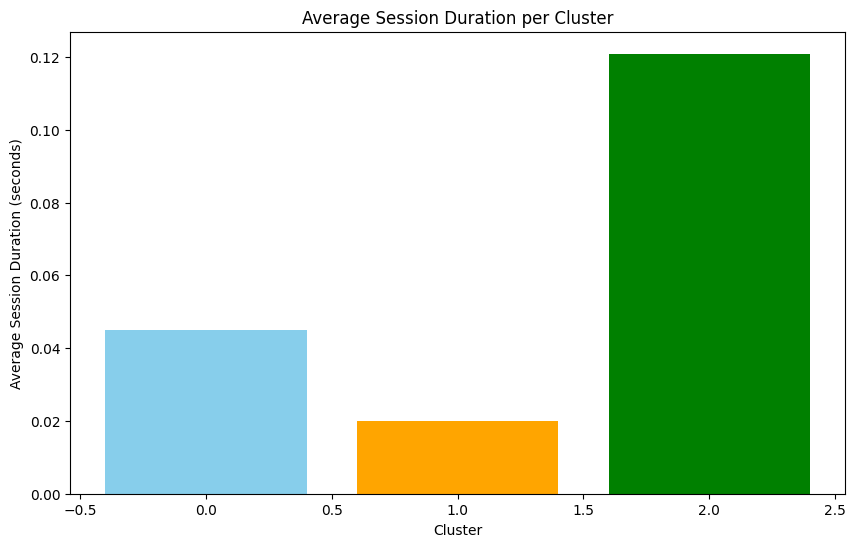

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(cluster_stats['Cluster'], cluster_stats['Dur. (s)']['mean'], color=['skyblue', 'orange', 'green'])
plt.title("Average Session Duration per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Session Duration (seconds)")
plt.show()

### while cluster 0 has medium average total traffic and total duration, cluster 1 has the lowest average total traffic and total duration, and cluster 2 has the highest average total traffic and total duration.

## Aggregation of user total traffic per application

In [68]:
df_user_engagement

,IMSI,MSISDN/Number,Dur. (s),Activity Duration DL (s),Activity Duration UL (s),Total DL (Megabytes),Total UL (Megabytes),Social Media DL (Megabytes),Social Media UL (Megabytes),Youtube DL (Megabytes),...,Email DL (Megabytes),Email UL (Megabytes),Gaming DL (Megabytes),Gaming UL (Megabytes),Other DL (Megabytes),Other UL (Megabytes),Avg RTT DL (s),Avg RTT UL (s),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,2.082014e+14,3.366496e+10,241.7635,37.6240,38.7870,294.570576,35.047284,1.474156,0.023289,15854611.0,...,3.248914,0.131380,265.199950,13.679647,163.788271,8.406060,0.042000,0.005000,23.0,44.0
1,2.082019e+14,3.368185e+10,241.7635,0.1680,3.5600,623.116460,51.308051,1.836884,0.006833,20247395.0,...,0.599905,0.294055,580.549311,1.116475,502.495039,14.357705,0.065000,0.005000,16.0,26.0
2,2.082003e+14,3.376063e+10,241.7635,0.1027,0.5897,266.845069,26.591909,1.606038,0.040268,19725661.0,...,2.565528,0.641797,218.948956,0.794487,391.666973,4.020465,0.108225,0.017637,11.0,18.0
3,2.082014e+14,3.375034e+10,241.7635,3.3300,37.8820,795.636628,41.317194,0.614282,0.012753,21388122.0,...,1.373056,0.601987,762.499002,10.347101,714.340146,12.204440,0.108225,0.017637,44.0,44.0
4,2.082014e+14,3.369980e+10,241.7635,0.1027,0.5897,542.772855,36.757292,0.822639,0.047863,15259380.0,...,1.846786,0.165799,503.260849,3.366281,525.197506,13.265917,0.108225,0.017637,11.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,2.082014e+14,3.366865e+10,59.5870,3380.3810,2355.7300,781.074970,51.255600,0.917527,0.029638,6550499.0,...,3.248914,0.782148,748.095847,12.135268,306.494867,14.200674,0.224000,0.009000,62569.0,1393.0
149996,2.082022e+14,3.365069e+10,81.2300,42.3760,41.9150,547.576198,54.959155,3.245710,0.049678,16191667.0,...,0.168819,0.603902,502.214120,8.771140,39.816477,12.862602,0.032000,0.001000,52.0,65.0
149997,2.082019e+14,3.366345e+10,97.9700,17.2640,16.7590,635.765881,37.322122,2.235954,0.007260,13877234.0,...,1.863874,0.159554,597.851812,4.515679,679.188144,2.343901,0.027000,0.002000,23.0,54.0
149998,2.082017e+14,3.362189e+10,98.2490,25.0030,28.6400,565.325170,33.294891,1.188130,0.013727,22076979.5,...,1.455053,0.507873,527.896389,12.773815,115.490776,10.790566,0.043000,0.006000,43.0,47.0


In [72]:
applications = {
    'Social Media': ('Social Media DL (Megabytes)', 'Social Media UL (Megabytes)'),
    'Youtube': ('Youtube DL (Megabytes)', 'Youtube UL (Megabytes)'),
    'Netflix': ('Netflix DL (Megabytes)', 'Netflix UL (Megabytes)'),
    'Google': ('Google DL (Megabytes)', 'Google UL (Megabytes)'),
    'Email': ('Email DL (Megabytes)', 'Email UL (Megabytes)'),
    'Gaming': ('Gaming DL (Megabytes)', 'Gaming UL (Megabytes)'),
    'Other': ('Other DL (Megabytes)', 'Other UL (Megabytes)')
}


In [74]:
top_users_per_app = {}

In [75]:
for app, (dl_col, ul_col) in applications.items():
    print(f"\nProcessing {app}...")

    # Check if the columns exist in the DataFrame
    if dl_col in df_user_engagement.columns and ul_col in df_user_engagement.columns:
        # Aggregate total traffic (DL + UL) per user
        total_traffic_per_user = (
            df_user_engagement.groupby('MSISDN/Number')[[dl_col, ul_col]]
            .sum()
            .sum(axis=1)  # Sum DL and UL
            .reset_index(name='Total Traffic')
            .sort_values(by='Total Traffic', ascending=False)
            .head(10)
        )
        
        # Store the top 10 users for the current application
        top_users_per_app[app] = total_traffic_per_user
        
        # Print the top 10 users
        print(f"Top 10 Most Engaged Users for {app}:")
        print(total_traffic_per_user)
        print("\n")
    else:
        print(f"Columns '{dl_col}' or '{ul_col}' not found in DataFrame.")
        print("\n")


Processing Social Media...
Top 10 Most Engaged Users for Social Media:
        MSISDN/Number  Total Traffic
13526    3.362632e+10      41.332835
92923    3.376054e+10      37.917794
37052    3.365973e+10      33.695599
6437     3.361489e+10      26.983130
13180    3.362578e+10      25.862265
65118    3.366716e+10      23.124163
106137   3.378632e+10      22.727303
70960    3.366907e+10      22.699772
666      3.360313e+10      21.938982
31331    3.365849e+10      21.820822



Processing Youtube...
Top 10 Most Engaged Users for Youtube:
       MSISDN/Number  Total Traffic
13180   3.362578e+10    450849012.4
92923   3.376054e+10    395742134.9
6437    3.361489e+10    392686657.7
13526   3.362632e+10    375463684.5
76363   3.367588e+10    318713617.9
65118   3.366716e+10    315552605.6
13994   3.362708e+10    308364023.0
92577   3.376041e+10    303001988.5
86455   3.369879e+10    300683014.2
666     3.360313e+10    283377421.5



Processing Netflix...
Top 10 Most Engaged Users for Netfli

### Plotting the top 3 most used applications

In [76]:
total_traffic_per_app = {}

In [82]:
# Calculate total traffic for each application
for app, (dl_col, ul_col) in applications.items():
    if dl_col in df_user_engagement.columns and ul_col in df_user_engagement.columns:
        # Aggregate total traffic (DL + UL) per user
        total_traffic = (
            df_user_engagement[[dl_col, ul_col]]
            .sum()  # Sum DL and UL for all users
        ).sum()  # Sum across all applications
        
        # Store the total traffic for the current application
        total_traffic_per_app[app] = total_traffic

In [78]:
# Convert the dictionary to a DataFrame for easier plotting
traffic_df = pd.DataFrame(list(total_traffic_per_app.items()), columns=['Application', 'Total Traffic'])

# Sort applications by total traffic and get the top 3
top_3_apps = traffic_df.sort_values(by='Total Traffic', ascending=False).head(3)


In [81]:
top_3_apps

,Application,Total Traffic
1,Youtube,3.372115e+12
5,Gaming,6.112189e+07
6,Other,6.099114e+07


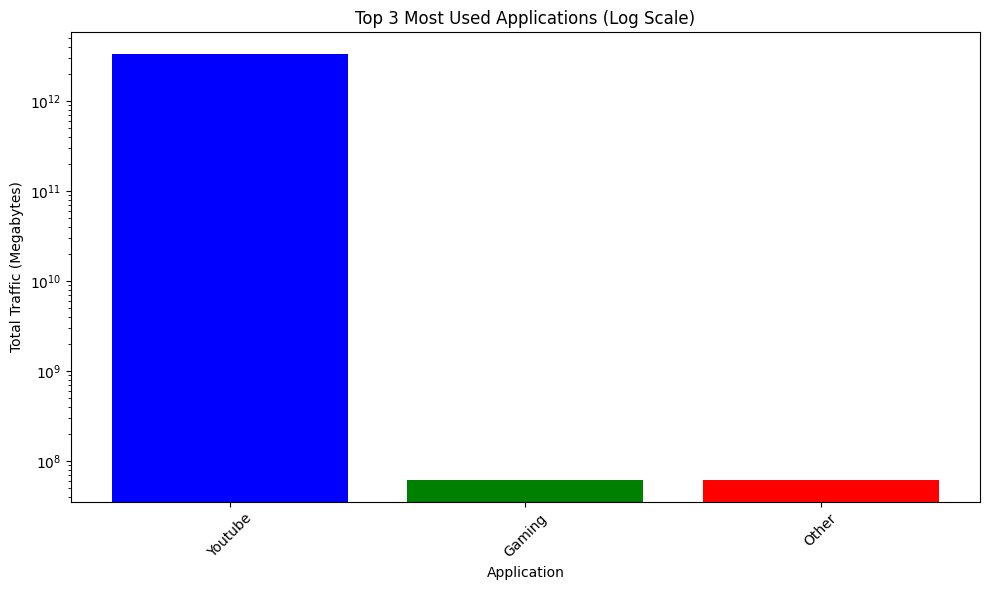

In [83]:
# Plot the top 3 most used applications with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.bar(top_3_apps['Application'], top_3_apps['Total Traffic'], color=['blue', 'green', 'red'])
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Application')
plt.ylabel('Total Traffic (Megabytes)')
plt.title('Top 3 Most Used Applications (Log Scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## K-Means Clustering and Find Optimal k

In [86]:
metrics = df_user_engagement[['Dur. (s)', 'Activity Duration DL (s)', 'Activity Duration UL (s)',
                              'Total DL (Megabytes)', 'Total UL (Megabytes)',
                              'Social Media DL (Megabytes)', 'Social Media UL (Megabytes)',
                              'Youtube DL (Megabytes)', 'Youtube UL (Megabytes)',
                              'Netflix DL (Megabytes)', 'Netflix UL (Megabytes)',
                              'Google DL (Megabytes)', 'Google UL (Megabytes)',
                              'Email DL (Megabytes)', 'Email UL (Megabytes)',
                              'Gaming DL (Megabytes)', 'Gaming UL (Megabytes)',
                              'Other DL (Megabytes)', 'Other UL (Megabytes)']]

In [87]:
# Normalizing the data
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(metrics)

# Elbow Method to find the optimal number of clusters
wcss = []
k_range = range(1, 11)  # Trying k from 1 to 10


In [88]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_metrics)
    wcss.append(kmeans.inertia_)

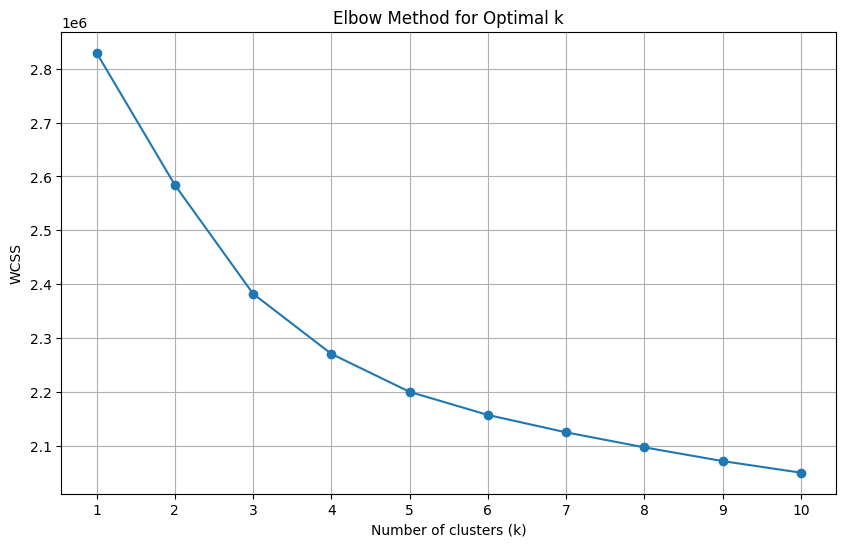

In [89]:
# Plotting WCSS to find the elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### The optimal number of clusters seems to be 3 or 4 but we will use 4 clusters for this analysis...since we tried 3 clusters in the previous analysis

In [95]:
optimal_k = 4


In [96]:
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
df_user_engagement['Cluster'] = kmeans.fit_predict(scaled_metrics)

In [97]:
# Analyze and interpret the results
cluster_summary = df_user_engagement.groupby('Cluster').mean()


In [98]:
print("Cluster Summary:")
cluster_summary

Cluster Summary:


,IMSI,MSISDN/Number,Dur. (s),Activity Duration DL (s),Activity Duration UL (s),Total DL (Megabytes),Total UL (Megabytes),Social Media DL (Megabytes),Social Media UL (Megabytes),Youtube DL (Megabytes),...,Email DL (Megabytes),Email UL (Megabytes),Gaming DL (Megabytes),Gaming UL (Megabytes),Other DL (Megabytes),Other UL (Megabytes),Avg RTT DL (s),Avg RTT UL (s),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2.082017e+14,3.367360e+10,101.925333,426.860104,354.188313,413.407615,28.060190,1.699049,0.031577,1.160459e+07,...,1.707492,0.440894,382.412710,5.931483,401.478803,5.941512,0.070054,0.010568,9008.851609,919.417003
1,2.082016e+14,3.368353e+10,85.719215,8947.328093,6179.560444,432.299642,39.239848,1.713746,0.031262,1.167141e+07,...,1.711876,0.446373,401.166016,7.870104,405.056308,7.896330,0.095370,0.027761,39631.881256,5361.115055
2,2.082017e+14,4.085242e+10,101.030981,432.188634,358.500747,652.904930,43.855862,1.717413,0.031308,1.170087e+07,...,1.712957,0.448141,621.752513,8.745107,400.197041,8.681621,0.070558,0.010727,9090.618143,922.291821
3,2.082015e+14,5.356423e+10,101.324903,431.700411,361.160780,222.242300,45.099355,1.717768,0.031362,1.157710e+07,...,1.704300,0.447718,191.174692,8.942330,402.198229,8.907251,0.070189,0.010608,9033.584973,928.414169
